<a href="https://colab.research.google.com/github/thaispatricio9/awari-bookstore/blob/main/book_recommendation_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sistema de Recomendação de Livros com Surprise

## Instalar pacotes

In [ ]:
# Instalar a biblioteca Surprise
!pip install surprise

In [ ]:
!pip install cdifflib

In [ ]:
!pip install streamlit

## Funções

In [ ]:
def get_book_id(book_title, metadata):
    
    """
    Gets the book ID for a book title based on the closest match in the metadata dataframe.
    """
    
    existing_titles = list(metadata['Book-Title'].values)
    closest_titles = difflib.get_close_matches(book_title, existing_titles)
    book_id = metadata[metadata['Book-Title'] == closest_titles[0]]['ISBN'].values[0]
    return book_id

def get_book_info(book_id, metadata, rating):
    
    """
    Returns some basic information about a book given the book id and the metadata dataframe.
    """
    
    book_info = metadata[metadata['ISBN'] == book_id][['ISBN', 'Book-Author', 'Book-Title']]
    info = book_info.to_dict(orient='records')[0]
    info["rating"]=rating
    return info

def predict_review(user_id, book_title, model, metadata):
    
    """
    Predicts the review (on a scale of 1-5) that a user would assign to a specific book. 
    """
    
    book_id = get_book_id(book_title, metadata)
    review_prediction = model.predict(uid=user_id, iid=book_id)
    return review_prediction.est

def generate_recommendation(user_id, model, metadata, thresh=4):
    
    """
    Generates a book recommendation for a user based on a rating threshold. Only
    books with a predicted rating at or above the threshold will be recommended
    """
    read_books = list(metadata[metadata['User-ID'] == user_id]['Book-Title'].unique())
    book_titles = list(metadata['Book-Title'].values)
    random.shuffle(book_titles)

    recommendations = []
    book = 1
    for book_title in book_titles:
      if book_title not in read_books:  
        rating = predict_review(user_id, book_title, model, metadata)
        if rating >= thresh:
          book_id = get_book_id(book_title, metadata)
          recommendations.append(get_book_info(book_id, metadata, rating))
          if book >= 3:
            return recommendations
          book += 1
    return recommendation

## Importar dados e bilbiotecas

In [ ]:
# Importar bilbiotecas
import pandas as pd
from surprise import Dataset
from surprise import Reader
from surprise import SVD
from surprise import BaselineOnly, NMF, CoClustering, NormalPredictor
from surprise import accuracy
from surprise.model_selection import cross_validate, train_test_split
import difflib
import random
from PIL import Image
import urllib.request
import matplotlib.pyplot as plt
import matplotlib.image as img
import seaborn as sns
import io

sns.set()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dir = "/content/drive/MyDrive/Awari/Projeto/Dados/"

In [ ]:
# Ler os aquivos como dataframes
books = pd.read_csv(f'{dir}Books.csv')
users = pd.read_csv(f'{dir}Users.csv')
ratings = pd.read_csv(f'{dir}Ratings.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  """A safe version of the builtin execfile().


## Preparação dos dados

Unir os dataframes e limpar os dados deixando apenas as colunas necessárias

In [ ]:
# Merge files
data = ratings.merge(books, on = 'ISBN').merge(users, on='User-ID')

In [ ]:
data.info

<bound method DataFrame.info of          User-ID        ISBN  ...                          Location   Age
0         276725  034545104X  ...                 tyler, texas, usa   NaN
1           2313  034545104X  ...             cincinnati, ohio, usa  23.0
2           2313  0812533550  ...             cincinnati, ohio, usa  23.0
3           2313  0679745580  ...             cincinnati, ohio, usa  23.0
4           2313  0060173289  ...             cincinnati, ohio, usa  23.0
...          ...         ...  ...                               ...   ...
1031131   276442  2862749796  ...       genève, genève, switzerland  62.0
1031132   276618  3788097000  ...      stuttgart, \n/a\"., germany"   NaN
1031133   276647  0553571001  ...  arlington heights, illinois, usa  13.0
1031134   276647  0689822294  ...  arlington heights, illinois, usa  13.0
1031135   276660  0583307841  ...         singapore, n/a, singapore  15.0

[1031136 rows x 12 columns]>

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1031136 entries, 0 to 1031135
Data columns (total 12 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   User-ID              1031136 non-null  int64  
 1   ISBN                 1031136 non-null  object 
 2   Book-Rating          1031136 non-null  int64  
 3   Book-Title           1031136 non-null  object 
 4   Book-Author          1031135 non-null  object 
 5   Year-Of-Publication  1031136 non-null  object 
 6   Publisher            1031134 non-null  object 
 7   Image-URL-S          1031136 non-null  object 
 8   Image-URL-M          1031136 non-null  object 
 9   Image-URL-L          1031132 non-null  object 
 10  Location             1031136 non-null  object 
 11  Age                  753301 non-null   float64
dtypes: float64(1), int64(2), object(9)
memory usage: 102.3+ MB


In [ ]:
data.drop_duplicates(inplace=True)

## EDA

**Distribuição das avaliações**

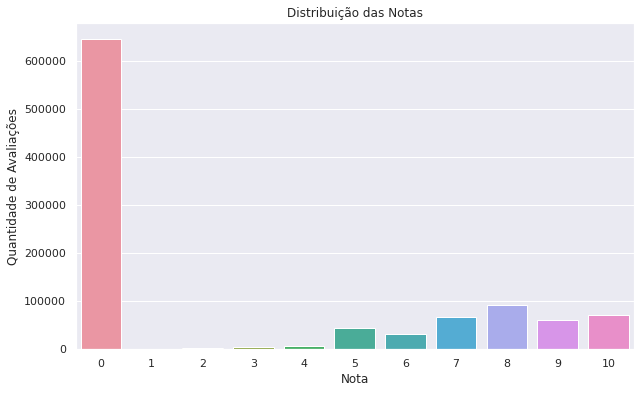

In [ ]:
plt.figure(figsize=(10,6))
df = data['Book-Rating'].value_counts().sort_index(ascending = False)
ax = sns.barplot(x=df.index, y=df.values)
ax.set(xlabel= 'Nota', ylabel='Quantidade de Avaliações', title='Distribuição das Notas')
plt.show()

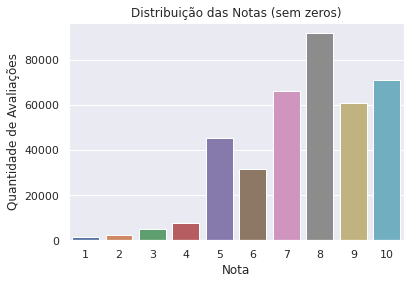

In [ ]:
df = df[df.index>0]
ax = sns.barplot(x=df.index, y=df.values)
ax.set(xlabel= 'Nota', ylabel='Quantidade de Avaliações', title='Distribuição das Notas (sem zeros)')
plt.show()

**Distribuição das avaliações por livro**

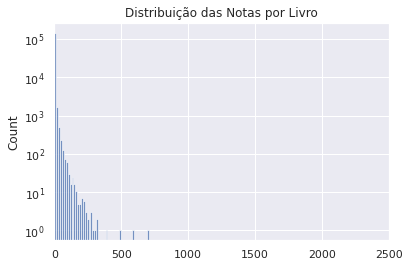

In [ ]:
df = data[data['Book-Rating']>0].groupby('ISBN')['Book-Rating'].count().sort_values(ascending=False)
sns.histplot(data=df, x=df.values, bins=50)
plt.yscale("log")
plt.xlim(left=0, right=2500)
plt.title('Distribuição das Notas por Livro')
plt.show()

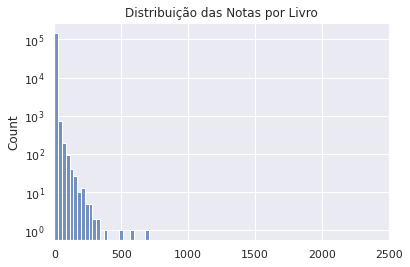

In [ ]:
d1 = data[data['Book-Rating']>0]
d1 = d1.groupby('ISBN')['Book-Rating'].size().sort_values(ascending=False)
sns.histplot(data=d1, x=d1.values, bins=25)
plt.yscale("log")
plt.xlim(left=0, right=2500)
plt.title('Distribuição das Notas por Livro')
plt.show()

**Distribuição das Avaliações por Usuário**

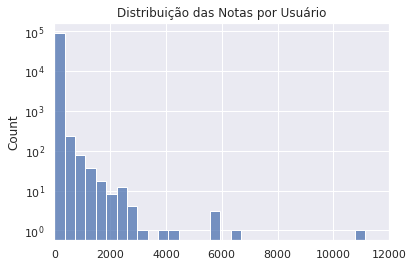

In [ ]:
df = data.groupby('User-ID')['Book-Rating'].count().sort_values(ascending=False)
sns.histplot(data=df, x=df.values, bins=30)
plt.yscale("log")
plt.xlim(left=0, right=12000)
plt.title('Distribuição das Notas por Usuário')
plt.show()

In [ ]:
new_data = data[data['Book-Rating']>0]

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


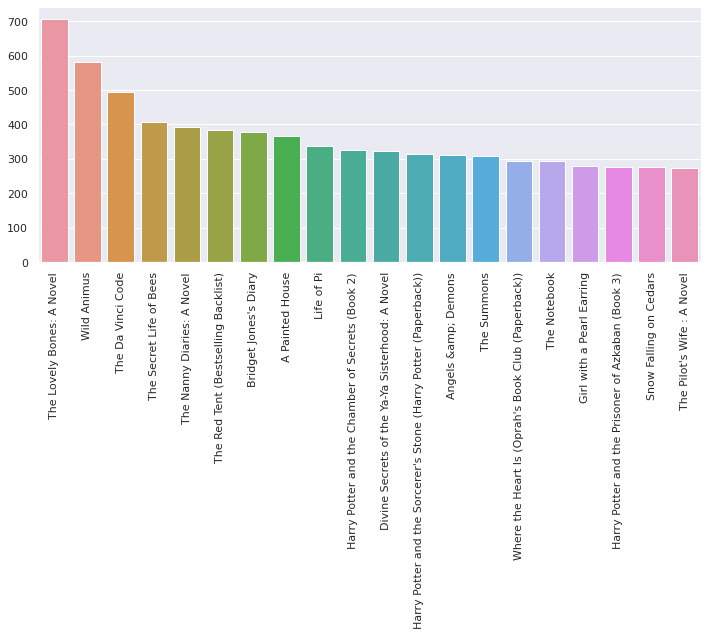

In [ ]:
titulos = new_data['Book-Title'].value_counts().nlargest(20)
plt.figure(figsize=(10,9))
sns.barplot(titulos.index, titulos.values)
plt.xticks(rotation=90)
#plt.title('Titulos mais avaliados')
plt.tight_layout()
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


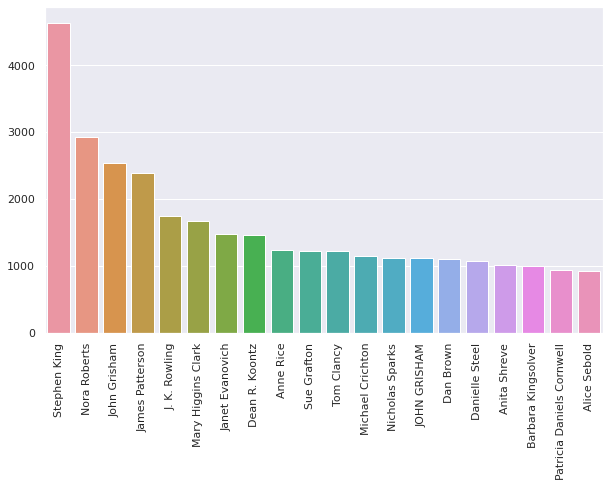

In [ ]:
autores = new_data['Book-Author'].value_counts().nlargest(20)
plt.figure(figsize=(10,6))
sns.barplot(autores.index, autores.values)
plt.ylabel = 'Avaliações'
plt.xticks(rotation=90)
#plt.title('Autores mais avaliados')
#plt.tight_layout()
plt.show()


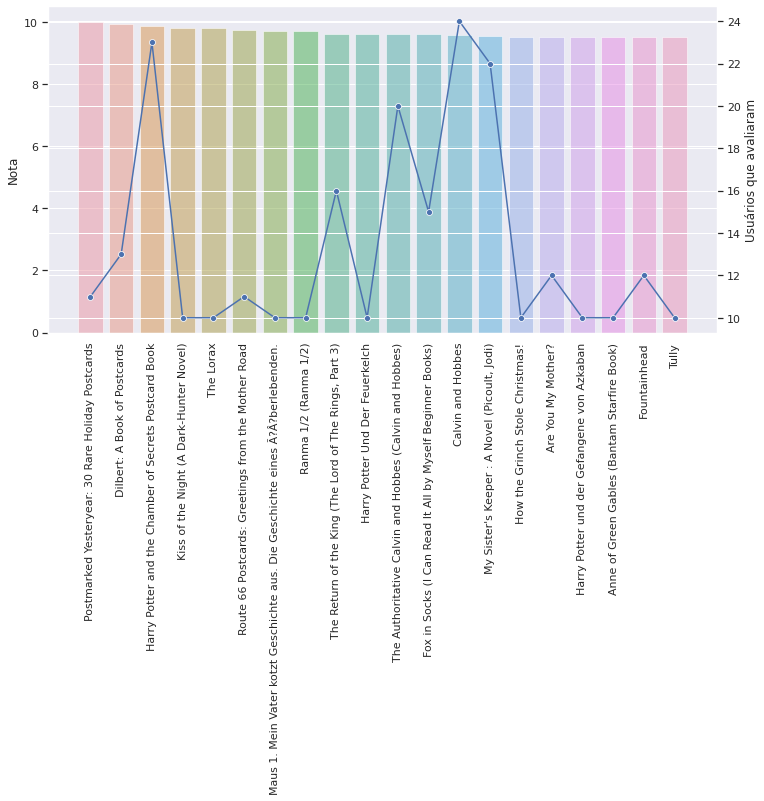

In [ ]:
avaliados_pos = new_data.groupby(["Book-Title"]).agg({"Book-Rating": "mean", "User-ID": "count"}).sort_values(by = 'Book-Rating', ascending=False)
avaliados_pos = avaliados_pos[avaliados_pos["User-ID"] >= 10][:20]


fig, ax1 = plt.subplots(figsize=(12,6))
sns.barplot(data = avaliados_pos, x = avaliados_pos.index, y='Book-Rating', alpha=0.5, ax=ax1)
plt.xticks(rotation=90)
ax1.set(ylabel='Nota', xlabel='')
ax2 = ax1.twinx()
sns.lineplot(data = avaliados_pos, x = avaliados_pos.index, y='User-ID', marker='o', sort = False, ax=ax2)
plt.xticks(rotation=90)
ax2.set(ylabel='Usuários que avaliaram')

plt.show()


## Limpeza dos dados

Para reduzir a dimencionalidade do dataset e evitar erros de memória e no modelo, irei filtrar as avaliações zero
  * Avaliações zero significam que a pessoa não avaliou o livro.

In [ ]:
data.groupby(['ISBN'])['Book-Rating'].count().mean()

3.816887592494568

In [ ]:
d1 = data.groupby(['ISBN'])['Book-Rating'].count()
d1.median()

1.0

In [ ]:
new_data = data[data['Book-Rating']>0]

In [ ]:
red = (new_data.shape[0]/data.shape[0])*100

print("Redução do Dataset de %d para %d: %.2f %%" %(data.shape[0], new_data.shape[0], red))

Redução do Dataset de 1031136 para 383842: 37.23 %


In [ ]:
new_ratings = ratings[ratings['Book-Rating'] > 0]
User_rating_mean = new_ratings.groupby('User-ID')['Book-Rating'].mean()
User_rating_count = new_ratings.groupby('User-ID')['Book-Rating'].count()
new_ratings = new_ratings.set_index('User-ID')

new_ratings['mean_rating'] = User_rating_mean
new_ratings['count_rating'] = User_rating_count
new_ratings.reset_index(inplace=True)

print(new_ratings.shape)
new_ratings.head()

(433671, 5)


,User-ID,ISBN,Book-Rating,mean_rating,count_rating
0,276726,0155061224,5,5.0,1
1,276729,052165615X,3,4.5,2
2,276729,0521795028,6,4.5,2
3,276736,3257224281,8,8.0,1
4,276737,0600570967,6,6.0,1


In [ ]:
new_ratings.describe()

,User-ID,Book-Rating,mean_rating,count_rating
count,433671.000000,433671.000000,433671.000000,433671.000000
mean,135458.743451,7.601066,7.601066,352.937160
std,80678.385078,1.843798,1.179386,1352.150423
min,8.000000,1.000000,1.000000,1.000000
25%,66619.000000,7.000000,7.000000,6.000000
50%,133184.000000,8.000000,7.666667,29.000000
75%,205735.000000,9.000000,8.356079,115.000000
max,278854.000000,10.000000,10.000000,8524.000000


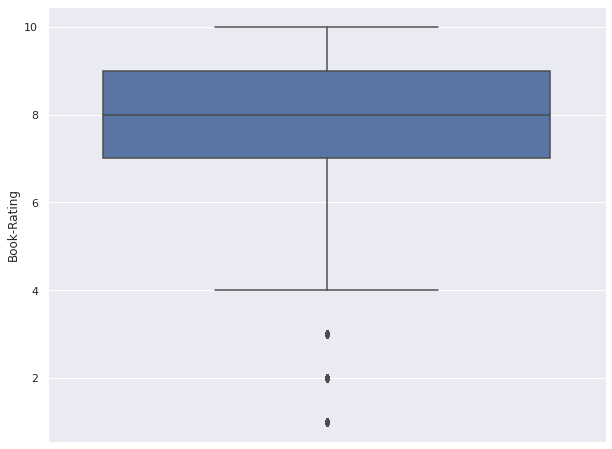

In [ ]:
plt.figure(figsize=(10,8))
sns.boxplot(y=new_ratings['Book-Rating'])

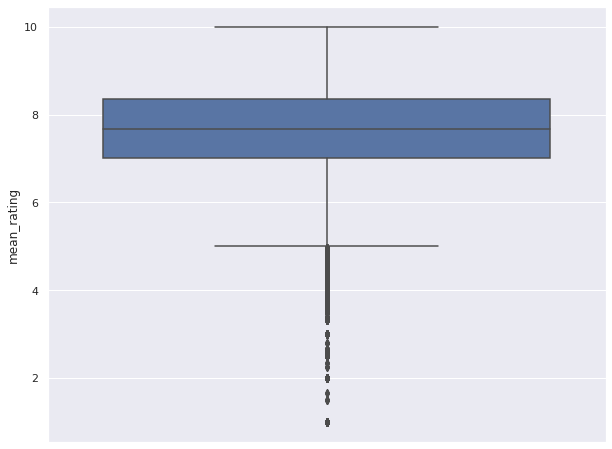

In [ ]:
plt.figure(figsize=(10,8))
sns.boxplot(y=new_ratings['mean_rating'])

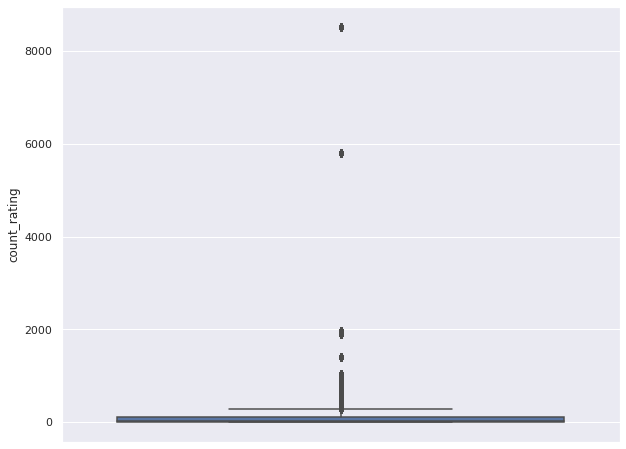

In [ ]:
plt.figure(figsize=(10,8))
sns.boxplot(y=new_ratings['count_rating'])

In [ ]:
tamanhos = []
for i in range(100, -1, -2):
  new_data_teste = new_data[new_data.groupby('ISBN')['ISBN'].transform('size') > i]
  s = new_data_teste.shape[0]
  r = 1 - new_data_teste.shape[0]/new_data.shape[0]
  tamanhos.append([i, s, r])

In [ ]:
tam = pd.DataFrame(tamanhos, columns = ['Avaliação Mínima', 'Shape', 'Redução'])

<Figure size 864x720 with 0 Axes>

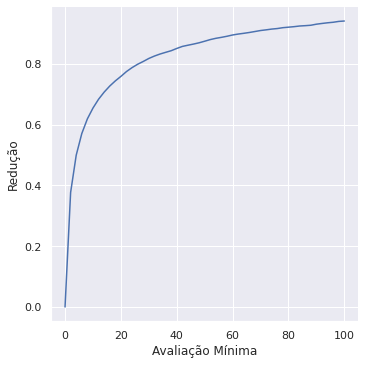

In [ ]:
plt.figure(figsize=(12,10))
sns.relplot(data = tam, y='Redução', x='Avaliação Mínima', kind='line')

In [ ]:
new_data = new_data[new_data.groupby('ISBN')['ISBN'].transform('size') >= 10]
# Comparar o tamanho do dataset original com o filtrado
print('Tamanho do dataset original:\t{}'.format(data.shape))
print('Tamanho do novo dataset:\t{}'.format(new_data.shape))

Tamanho do dataset original:	(1031136, 12)
Tamanho do novo dataset:	(139296, 12)


In [ ]:
new_data.groupby(['User-ID'])['Book-Rating'].count().sort_values(ascending=False)

User-ID
11676     1894
16795      339
98391      315
153662     302
95359      283
          ... 
162784       1
162796       1
162809       1
162818       1
9            1
Name: Book-Rating, Length: 39365, dtype: int64

In [ ]:
new_data.groupby(['ISBN'])['Book-Rating'].count().sort_values(ascending=False)

ISBN
0316666343    707
0971880107    581
0385504209    487
0312195516    383
0060928336    320
             ... 
0440415632     10
0440428130     10
0440442508     10
0440479002     10
0002558122     10
Name: Book-Rating, Length: 5444, dtype: int64

## Modelo
Construção do modelo usando a biblioteca Surprise

Para carregar um conjunto de dados do DataFrame do pandas, usaremos o método load_from_df(), também precisaremos de um objeto Reader e o parâmetro rating_scale deve ser especificado, no caso nossas avaliações vão de 1 a 10. O DataFrame deve ter três colunas, correspondendo aos ids do usuário, aos ids dos livros e às avaliações, nesta ordem. Cada linha corresponde, portanto, a uma determinada avaliação.

In [ ]:
reader = Reader(rating_scale=(1, 10))
df = Dataset.load_from_df(new_data[['User-ID', 'ISBN', 'Book-Rating']], reader)

O Surprise oferece vários **modelos** como:
*   **NormalPredictor**: Algoritmo que prevê uma classificação aleatória com base na distribuição do conjunto de treinamento, que é considerado normal.
*   **BaselineOnly**: Algoritmo que prevê a estimativa da linha de base para determinado usuário e item.
*   **kNN algorithms**: Estes são algoritmos derivados diretamente de uma abordagem básica de vizinhos mais próximos, como KNNBasic, KNNWithMeans, KNNWithZScore e KNNBaseline.
*   **Matrix-Factorization**: Estes são algorítmos com base em fatorização de matrizes, como SVD, SVDpp e NMF

Bom base nos resultados de outros estudos, iremos testar o BaselineOnly e o SVD.

In [ ]:
benchmark = []
# Iterate over all algorithms
for algorithm in [BaselineOnly(), CoClustering(), SVD(), NMF]:
    # Perform cross validation
    results = cross_validate(algorithm, df, measures=['RMSE','MSE', 'MAE'], cv=3, verbose=True)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
df_results = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')

Evaluating RMSE, MSE, MAE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.6466  1.6414  1.6407  1.6429  0.0026  
MSE (testset)     2.7113  2.6941  2.6918  2.6991  0.0087  
MAE (testset)     1.2713  1.2698  1.2673  1.2695  0.0017  
Fit time          17.85   18.08   18.11   18.01   0.12    
Test time         1.54    1.58    1.51    1.55    0.03    
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Evaluating RMSE, MSE, MAE of algorithm BaselineOnly on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.6443  1.6492  1.6475  1.6470  0.0021  
MSE (testset)     2.7036  2.7199  2.7142  2.7126  0.0068  
MAE (testset)     1.2790  1.2821  1.2802  1.2804  0.0013  
Fit time          2.34    2.49    2.60    2.48    0.10    
Test time         1.34    0.98    1.38    1.23    0.18    


In [ ]:
df_results

,test_rmse,test_mse,test_mae,fit_time,test_time
Algorithm,,,,,
SVD,1.642878,2.699056,1.269456,18.013120,1.545534
BaselineOnly,1.646985,2.712563,1.280442,2.476181,1.231092


In [ ]:
# Modelo escolhido
svd = SVD() # Método de decomposição matricial
cross_validate(svd, df, measures = ['RMSE', 'MSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.5999  1.6240  1.6031  1.5979  1.6225  1.6095  0.0114  
MSE (testset)     2.5596  2.6374  2.5699  2.5533  2.6325  2.5905  0.0367  
MAE (testset)     1.2382  1.2546  1.2455  1.2393  1.2507  1.2457  0.0064  
Fit time          7.96    7.60    7.92    7.71    8.01    7.84    0.16    
Test time         0.26    0.30    0.32    0.27    0.26    0.28    0.02    


{'fit_time': (7.958406686782837,
  7.602962255477905,
  7.916202545166016,
  7.709482908248901,
  8.007670402526855),
 'test_mae': array([1.23815882, 1.25463662, 1.24551401, 1.23932904, 1.25071606]),
 'test_mse': array([2.55958256, 2.6373995 , 2.5699162 , 2.55328836, 2.63248584]),
 'test_rmse': array([1.59986954, 1.62400723, 1.60309582, 1.59790124, 1.62249371]),
 'test_time': (0.26235103607177734,
  0.30400729179382324,
  0.3203272819519043,
  0.27446579933166504,
  0.26221370697021484)}

### Treino e Teste

Agora vamos dividir o dataset e teste e treino e coletar as melhores e piores predições para avaliar o modelo 

In [ ]:
trainset, testset = train_test_split(df, test_size=0.30, random_state=9, shuffle=False)

In [ ]:
svd = SVD()
predictions = svd.fit(trainset).test(testset)
accuracy.rmse(predictions)

RMSE: 1.2320


1.2320231258877092

In [ ]:
def get_Iu(uid):
    """ return the number of items rated by given user
    args: 
      uid: the id of the user
    returns: 
      the number of items rated by the user
    """
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError: # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    """ return number of users that have rated given item
    args:
      iid: the raw id of the item
    returns:
      the number of users that have rated the item.
    """
    try: 
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:
        return 0
    
df_pred = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
df_pred['Iu'] = df_pred.uid.apply(get_Iu)
df_pred['Ui'] = df_pred.iid.apply(get_Ui)
df_pred['err'] = abs(df_pred.est - df_pred.rui)
best_predictions = df_pred.sort_values(by='err'):50]
worst_predictions = df_pred.sort_values(by='err')[-50:]

SyntaxError: ignored

In [ ]:
best_predictions

In [ ]:
worst_predictions

In [ ]:
new_data[new_data['User-ID'] == 153718].tail(19)

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,Location,Age
43444,153718,042517140X,10,Loyalty in Death,J. D. Robb,2004,Berkley Publishing Group,http://images.amazon.com/images/P/042517140X.0...,http://images.amazon.com/images/P/042517140X.0...,http://images.amazon.com/images/P/042517140X.0...,"round lake, illinois, usa",27.0
43448,153718,0515133620,8,Tapestry,Lynn Kurland,2002,Jove Books,http://images.amazon.com/images/P/0515133620.0...,http://images.amazon.com/images/P/0515133620.0...,http://images.amazon.com/images/P/0515133620.0...,"round lake, illinois, usa",27.0
43451,153718,0373201346,7,Stanislaski Sisters (Harlequin by Request),Nora Roberts,1997,Harlequin,http://images.amazon.com/images/P/0373201346.0...,http://images.amazon.com/images/P/0373201346.0...,http://images.amazon.com/images/P/0373201346.0...,"round lake, illinois, usa",27.0
43453,153718,0373483694,9,Macgregor Grooms (Macgregors),Nora Roberts,1998,Silhouette,http://images.amazon.com/images/P/0373483694.0...,http://images.amazon.com/images/P/0373483694.0...,http://images.amazon.com/images/P/0373483694.0...,"round lake, illinois, usa",27.0
43457,153718,0425189058,9,Lover Beware,Christine Feehan,2003,Berkley Publishing Group,http://images.amazon.com/images/P/0425189058.0...,http://images.amazon.com/images/P/0425189058.0...,http://images.amazon.com/images/P/0425189058.0...,"round lake, illinois, usa",27.0
43458,153718,043965548X,10,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling,2004,Scholastic Paperbacks,http://images.amazon.com/images/P/043965548X.0...,http://images.amazon.com/images/P/043965548X.0...,http://images.amazon.com/images/P/043965548X.0...,"round lake, illinois, usa",27.0
43462,153718,0446364703,6,Decked : A Regan Reilly Mystery,Carol Higgins Clark,1993,Warner Books,http://images.amazon.com/images/P/0446364703.0...,http://images.amazon.com/images/P/0446364703.0...,http://images.amazon.com/images/P/0446364703.0...,"round lake, illinois, usa",27.0
43465,153718,0312992327,7,Public Displays of Affection,Susan Donovan,2004,St. Martin's Paperbacks,http://images.amazon.com/images/P/0312992327.0...,http://images.amazon.com/images/P/0312992327.0...,http://images.amazon.com/images/P/0312992327.0...,"round lake, illinois, usa",27.0
43469,153718,0373484895,8,Captive Star,Nora Roberts,2001,Silhouette,http://images.amazon.com/images/P/0373484895.0...,http://images.amazon.com/images/P/0373484895.0...,http://images.amazon.com/images/P/0373484895.0...,"round lake, illinois, usa",27.0
43470,153718,0312979975,8,Fantasy Lover,Sherrilyn Kenyon,2002,St. Martin's Press,http://images.amazon.com/images/P/0312979975.0...,http://images.amazon.com/images/P/0312979975.0...,http://images.amazon.com/images/P/0312979975.0...,"round lake, illinois, usa",27.0


In [ ]:
# Defina o ID do usuário para o qual a recomendaçãos erá feita
user_id = 153718

# Defina a nota mínima que os livros recomendados devem ter
nota_minima = 8.5

In [ ]:
recommendation = generate_recommendation(user_id, svd, data, nota_minima)

In [ ]:
recommendation

[{'Book-Author': 'ANNE FRANK',
  'Book-Title': 'Anne Frank: The Diary of a Young Girl',
  'ISBN': '0553296981',
  'rating': 8.69373028855227},
 {'Book-Author': 'MICHAEL CRICHTON',
  'Book-Title': 'Timeline',
  'ISBN': '0345417623',
  'rating': 8.502717679707704},
 {'Book-Author': 'J. K. Rowling',
  'Book-Title': 'Harry Potter and the Order of the Phoenix (Book 5)',
  'ISBN': '043935806X',
  'rating': 8.877532331402566}]

Recomendação 1: Anne Frank: The Diary of a Young Girl de ANNE FRANK



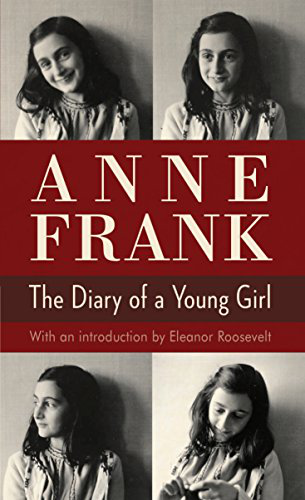



Recomendação 2: Timeline de MICHAEL CRICHTON



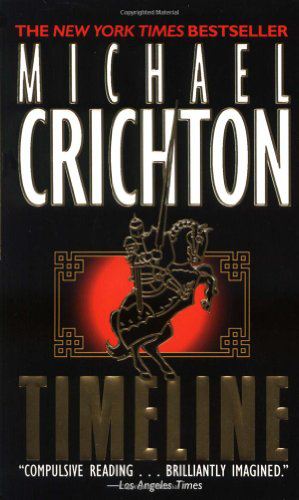



Recomendação 3: Harry Potter and the Order of the Phoenix (Book 5) de J. K. Rowling



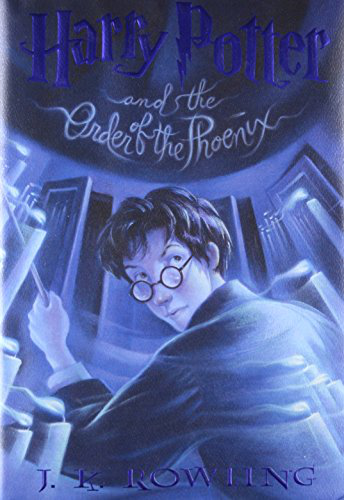

In [ ]:
for i in range(3):
  foto = data[data['ISBN'] == recommendation[i].get('ISBN')]['Image-URL-L'].unique()[0]
  with urllib.request.urlopen(foto) as url:
    with open('temp.jpg', 'wb') as f:
        f.write(url.read())
  img = Image.open('temp.jpg')
  print(f"Recomendação {i + 1}: {recommendation[i].get('Book-Title')} de {recommendation[i].get('Book-Author')}\n")
  display(img)
  print("\n")

In [ ]:
# Contar uma história sobre um usuário que gosta de x e Y livros e mostrar o resultado da recomendação
# Falar um pouco da Lib
# Discutir as aplicações
# Por fim o Front-end - SteamLit (ou Django)
# Pesquisar um pouco sobre o front-end em python - exemplos de uso
# Subir o notebook no Github e colocar na apresentação o link do github